## Applied Machine Learning Homework 2
### Task 2
Po-Chieh Liu

pl2441

In [1]:
# import base packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import sklearn packages
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors.nearest_centroid import NearestCentroid

# warning issue
import warnings
warnings.filterwarnings("ignore")

#### Import data
Use pandas to import data. **customerID** column is dropped. I assume it is not related to churner or not.

In [2]:
# read data
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.drop(columns=['customerID'], inplace =True)

# check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), object(17)
memory usage: 1.1+ MB


Although info shows no missing value, but there are some missing cells in **TotalCharges** column.

In [3]:
# replace the miissing values using np.na
df['TotalCharges'][df['TotalCharges']==' '] = np.nan
df['TotalCharges'] = df['TotalCharges'].astype('float64')

Based on the web page, lists of continuous, discrete and categorical features are created. There are 2 continuous, 1 discrete feature, and rest are categorical features.

In [4]:
# create variable lists
cts_list = ['MonthlyCharges', 'TotalCharges']
dis_list = ['tenure']
cat_list = [el for el in df.columns if el not in cts_list+dis_list]

## Task 2.1

#### Visualize the univariate distribution of each continuous feature, and the distribution of the target.

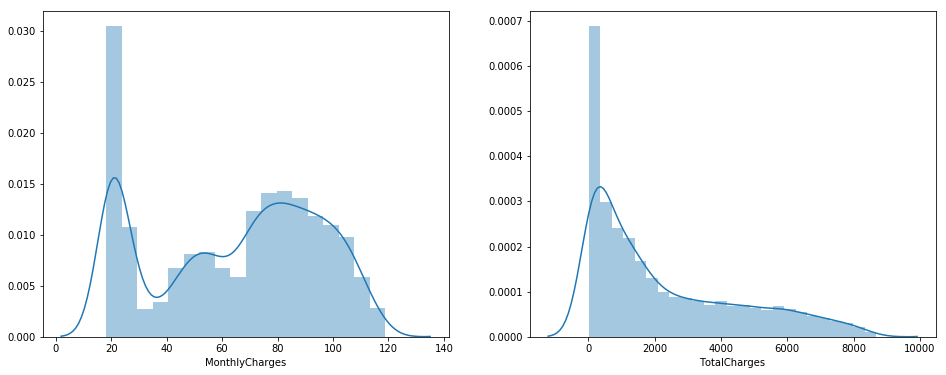

In [5]:
# extract continuous data
df_cts = df[cts_list].copy()

# generate plot using sns
# note, missing values are ignored here
fig1, axes1 = plt.subplots(1, 2, figsize = (16,6))
axis1 = axes1.flatten()
for i in range(len(axis1)):
    sns.distplot(df_cts[cts_list[i]].dropna(), ax = axis1[i])

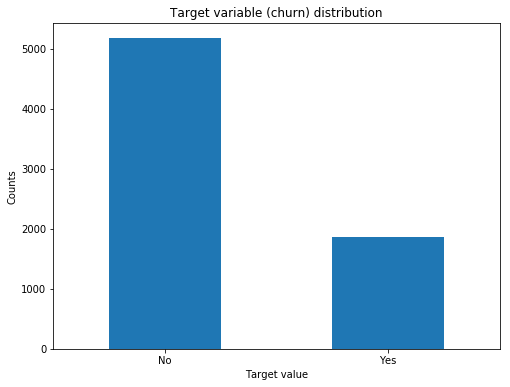

In [6]:
# visulize the target distribution
_ = df['Churn'].value_counts().plot(kind="bar", 
                figsize =(8,6),
                title = 'Target variable (churn) distribution',
                rot = False)
_ = plt.ylabel('Counts')
_ = plt.xlabel('Target value')

## Task 2.2

#### Split data into training and test set. Build a pipeline for dealing with categorical variables. Evaluate Logistic Regression, linear support vector machines and nearest centroids using cross-validation. How different are the results? How does scaling the continuous features with StandardScaler influence the results?

In [7]:
# split train and test data
X_train, X_test, Y_train, Y_test = train_test_split(
                                        df.iloc[:,0:-1], 
                                        df['Churn'], 
                                        random_state=0)

# impute missing total charge with mean
imp = SimpleImputer(strategy = 'mean').fit(
    X_train['TotalCharges'].values.reshape(-1, 1))
X_train['TotalCharges'] = imp.transform(
    X_train['TotalCharges'].values.reshape(-1, 1))

In [8]:
# preprocess pipe line, 
# using pwer transformer for continous variable 
# and one hot encoder for catagorical variable
preprocess = make_column_transformer(
    (PowerTransformer(method = 'yeo-johnson'), cts_list),
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_list[:-1]), 
    remainder='passthrough')

# preprocess pipe with standard scalar
preprocess_ = make_column_transformer(
    (StandardScaler(), cts_list),
    (PowerTransformer(method = 'yeo-johnson'), cts_list),
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_list[:-1]), 
    remainder='passthrough')

# make pipline without standard scalar
logistic_pipe = make_pipeline(preprocess, LogisticRegression(dual = False))
svc_pipe = make_pipeline(preprocess, LinearSVC(dual = False))
nc_pipe = make_pipeline(preprocess, NearestCentroid())

# with standard scalar
logistic_pipe_ = make_pipeline(preprocess_, LogisticRegression(dual = False))
svc_pipe_ = make_pipeline(preprocess_, LinearSVC(dual = False))
nc_pipe_ = make_pipeline(preprocess_, NearestCentroid())

In [9]:
print('Average score without standard scalar: ' + 
      str(np.mean(cross_val_score(logistic_pipe, X_train, Y_train))))

print('Average score with standard scalar: ' + 
      str(np.mean(cross_val_score(logistic_pipe_, X_train, Y_train))))

Average score without standard scalar: 0.8112451172715227
Average score with standard scalar: 0.8093517156230102


In [10]:
print('Average score without standard scalar: ' + 
      str(np.mean(cross_val_score(svc_pipe, X_train, Y_train))))

print('Average score with standard scalar: ' + 
      str(np.mean(cross_val_score(svc_pipe_, X_train, Y_train))))

Average score without standard scalar: 0.8099197898921067
Average score with standard scalar: 0.8087840715502556


In [11]:
print('Average score without standard scalar: ' + 
      str(np.mean(cross_val_score(nc_pipe, X_train, Y_train))))

print('Average score with standard scalar: ' + 
      str(np.mean(cross_val_score(nc_pipe_, X_train, Y_train))))

Average score without standard scalar: 0.6425631958425826
Average score with standard scalar: 0.6425631958425826


#### Task 2.2 Answer

From the simulation results, we can observe that scores of logistic regression and SVM are droped in order of $10^{-3}$. For nearest neighbors, the scores are almost the same.

## Task 2.3

#### Tune the parameters using GridSearchCV. Do the results improve? Visualize the performance as function of the parameters for all three models.

In [12]:
# preprocess X
X_preprocessed = preprocess_.fit_transform(X_train)

In [13]:
# parameter to search
param_grid = {'C': np.logspace(-4,1,16)}

# search
grid_logistic = GridSearchCV(LogisticRegression(dual = False), 
                             param_grid, cv=10)
grid_logistic.fit(X_preprocessed, Y_train)

# result
print(grid_logistic.best_params_)
print(grid_logistic.best_score_)

{'C': 0.21544346900318823}
0.8106777735706172


In [14]:
# function for result plot
def result_plot(result, title, xlabel, ylabel):
    # initial figure
    fig = plt.figure(figsize = (8,6))
    ax = fig.add_subplot(1, 1, 1)

    # training CI
    ax.fill_between(result.param_C.astype(float), 
                (result.mean_train_score.astype(float) + 
                 result.std_train_score.astype(float)), 
                (result.mean_train_score.astype(float) - 
                 result.std_train_score.astype(float)),
                color = 'b',
                alpha=0.25)
    
    # training score
    ax.semilogx(result.param_C,
            result.mean_train_score,
            'bo-',
            label='training set CV score with Std.')
    
    # testing CI
    ax.fill_between(result.param_C.astype(float),
                (result.mean_test_score.astype(float) + 
                 result.std_test_score.astype(float)), 
                (result.mean_test_score.astype(float) - 
                 result.std_test_score.astype(float)),
                color = 'g',
                alpha=0.25)
    
    # testing score            
    ax.semilogx(result.param_C,
            result.mean_test_score,
            'go-',
            label='testing set CV score with Std.')
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    _ = plt.legend(loc = 2)

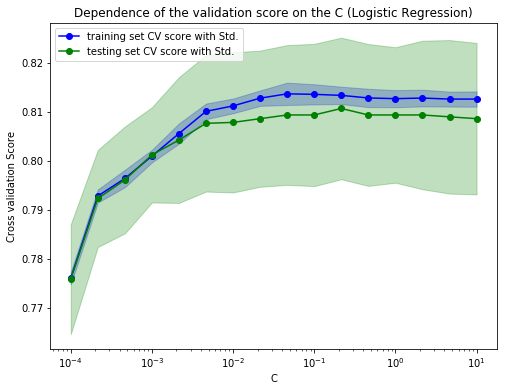

In [15]:
# extract result
result = pd.DataFrame(grid_logistic.cv_results_)

# generate plot
result_plot(result,
            'Dependence of the validation score on the C (Logistic Regression)',
            'C',
            'Cross validation Score')

In [16]:
# parameter to search
param_grid = {'C': np.logspace(-4,1,16)}

# search
grid_svd = GridSearchCV(LinearSVC(dual = False), param_grid, cv=10)
grid_svd.fit(X_preprocessed, Y_train)

# result
print(grid_svd.best_params_)
print(grid_svd.best_score_)

{'C': 0.046415888336127774}
0.8108670957970465


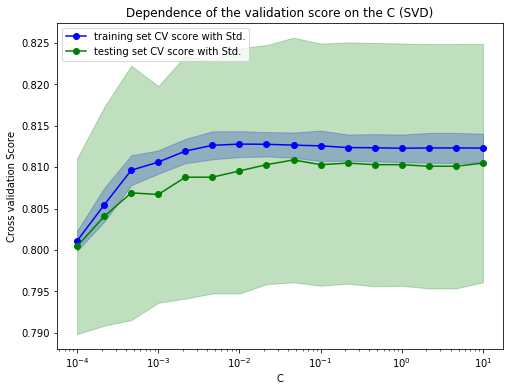

In [17]:
# extract result
result = pd.DataFrame(grid_svd.cv_results_)

# generate plot
result_plot(result,
            'Dependence of the validation score on the C (SVD)',
            'C',
            'Cross validation Score')

In [18]:
# parameter to search
param_grid = {'shrink_threshold': np.logspace(-4,1,16)}

# search
grid_nc = GridSearchCV(NearestCentroid(), param_grid)
grid_nc.fit(X_preprocessed, Y_train)

# results
print(grid_nc.best_params_)
print(grid_nc.best_score_)

{'shrink_threshold': 0.0001}
0.6425596365013253


In [19]:
# function for result plot 2
def result_plot2(result, title, xlabel, ylabel):
    # initial figure
    fig = plt.figure(figsize = (8,6))
    ax = fig.add_subplot(1, 1, 1)

    # training CI
    ax.fill_between(result.param_shrink_threshold.astype(float), 
                (result.mean_train_score.astype(float) + 
                 result.std_train_score.astype(float)), 
                (result.mean_train_score.astype(float) - 
                 result.std_train_score.astype(float)),
                color = 'b',
                alpha=0.25)
    
    # training score
    ax.semilogx(result.param_shrink_threshold,
            result.mean_train_score,
            'bo-',
            label='training set CV score with Std.')
    
    # testing CI
    ax.fill_between(result.param_shrink_threshold.astype(float),
                (result.mean_test_score.astype(float) + 
                 result.std_test_score.astype(float)), 
                (result.mean_test_score.astype(float) - 
                 result.std_test_score.astype(float)),
                color = 'g',
                alpha=0.25)
    
    # testing score            
    ax.semilogx(result.param_shrink_threshold,
            result.mean_test_score,
            'go-',
            label='testing set CV score with Std.')
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    _ = plt.legend(loc = 3)

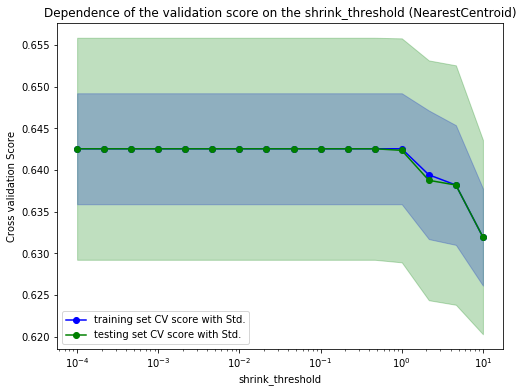

In [20]:
# extract result
result = pd.DataFrame(grid_nc.cv_results_)

# generate plot
result_plot2(result,
    'Dependence of the validation score on the shrink_threshold (NearestCentroid)',
    'shrink_threshold',
    'Cross validation Score')

#### Task 2.3 Answer

Compared with task 2.2 results, the grid search score of SVM is slightly increased. For logistic and nearest neighbor models, the scores are very close to previous results.

## Task 2.4

#### Change the cross-validation strategy from ‘stratified k-fold’ to ‘kfold’ with shuffling. Do the parameters that are found change? Do they change if you change the random seed of the shuffling? Or if you change the random state of the split into training and test data?

#### Task 2.4.1

In [21]:
# initiate k fold
kfold = KFold(n_splits=3,shuffle=True)

# parameter to search
param_grid = {'C': np.logspace(-4,1,16)}

# search
grid_logistic = GridSearchCV(LogisticRegression(dual = False), 
                             param_grid, cv=kfold)
grid_logistic.fit(X_preprocessed, Y_train)

# result
print(grid_logistic.best_params_)
print(grid_logistic.best_score_)

{'C': 0.1}
0.812570995834911


In [22]:
# parameter to search
param_grid = {'C': np.logspace(-4,1,16)}

# search
grid_svd = GridSearchCV(LinearSVC(dual = False), 
                        param_grid, cv=kfold)
grid_svd.fit(X_preprocessed, Y_train)

# result
print(grid_svd.best_params_)
print(grid_svd.best_score_)

{'C': 0.004641588833612777}
0.8112457402499054


In [23]:
# parameter to search
param_grid = {'shrink_threshold': np.logspace(-4,1,16)}

# search
grid_nc = GridSearchCV(NearestCentroid(), 
                       param_grid, cv = kfold)
grid_nc.fit(X_preprocessed, Y_train)

# results
print(grid_nc.best_params_)
print(grid_nc.best_score_)

{'shrink_threshold': 0.0001}
0.6412343809163196


#### Task 2.4.1 Answer

Changing the cross validation strategy to ‘kfold’ with shuffling does change the parameters for logistic regression C. For SVM and Nearest Neighbor models, the parameters are the same. 

Note, the modeling results might change for some randomness issue. I have seen several outcomes when I rerun the codes.

#### Task 2.4.2

In [24]:
# set seed
seed = 242
kfold = KFold(n_splits=3,shuffle=True,random_state=seed)

# parameter to search
param_grid = {'C': np.logspace(-4,1,16)}

# search
grid_logistic = GridSearchCV(LogisticRegression(dual = False), 
                             param_grid, cv=kfold)
grid_logistic.fit(X_preprocessed, Y_train)

# result
print(grid_logistic.best_params_)
print(grid_logistic.best_score_)

# for task 2.5 plot
lr_plot = grid_logistic.best_estimator_

{'C': 0.1}
0.8116243847027641


In [25]:
# parameter to search
param_grid = {'C': np.logspace(-4,1,16)}

# search
grid_svd = GridSearchCV(LinearSVC(dual = False), 
                        param_grid, cv=kfold)
grid_svd.fit(X_preprocessed, Y_train)

# result
print(grid_svd.best_params_)
print(grid_svd.best_score_)

# for task 2.5 plot
svd_plot = grid_svd.best_estimator_

{'C': 0.002154434690031882}
0.811056418023476


In [26]:
# parameter to search
param_grid = {'shrink_threshold': np.logspace(-4,1,16)}

# search
grid_nc = GridSearchCV(NearestCentroid(), 
                       param_grid, cv = kfold)
grid_nc.fit(X_preprocessed, Y_train)

# results
print(grid_nc.best_params_)
print(grid_nc.best_score_)

{'shrink_threshold': 1.0}
0.642938280954184


#### Task 2.4.2 Answer

All the parameters changed after applying new random seed number. 

Note1: I tested several seed number, for some seed numbers, the results are same as previous sections' results.

Note2: I ran the same script several times and the results are not the same. Even I set the random_state to a constant number. 

#### Task 2.4.3

In [27]:
# split train and test data
X_train_, X_test_, Y_train_, Y_test_ = train_test_split(
                                            df.iloc[:,0:-1], 
                                            df['Churn'], 
                                            random_state=889)

# impute missing total charge with mean
imp_ = SimpleImputer(strategy = 'mean').fit(
    X_train_['TotalCharges'].values.reshape(-1, 1))
X_train_['TotalCharges'] = imp_.transform(
    X_train_['TotalCharges'].values.reshape(-1, 1))

# preprocess data
X_preprocessed_ = preprocess_.fit_transform(X_train_)

In [28]:
# parameter to search
param_grid = {'C': np.logspace(-4,1,16)}

# search
grid_logistic = GridSearchCV(LogisticRegression(dual = False), 
                             param_grid)
grid_logistic.fit(X_preprocessed_, Y_train)

# result
print(grid_logistic.best_params_)
print(grid_logistic.best_score_)

{'C': 0.0001}
0.7338129496402878


In [29]:
# parameter to search
param_grid = {'C': np.logspace(-4,1,16)}

# search
grid_svd = GridSearchCV(LinearSVC(dual = False), param_grid)
grid_svd.fit(X_preprocessed_, Y_train)

# result
print(grid_svd.best_params_)
print(grid_svd.best_score_)

{'C': 0.0001}
0.7338129496402878


In [30]:
# parameter to search
param_grid = {'shrink_threshold': np.logspace(-4,1,16)}

# search
grid_nc = GridSearchCV(NearestCentroid(), param_grid)
grid_nc.fit(X_preprocessed_, Y_train)

# results
print(grid_nc.best_params_)
print(grid_nc.best_score_)

{'shrink_threshold': 2.154434690031882}
0.7338129496402878


#### Task 2.4.3 Answer

Changing the random seed number in the spliting process, all parameters are changed. For logistic regression and SVD, the C values change to $0.0001$. For nearest neighbor, the shrink threshold changes to $2.1544$.

## Task 2.5

#### Visualize the coefficients for LogisticRegression and Linear Support Vector Machines using hyper-parameters that performed well in the grid-search.

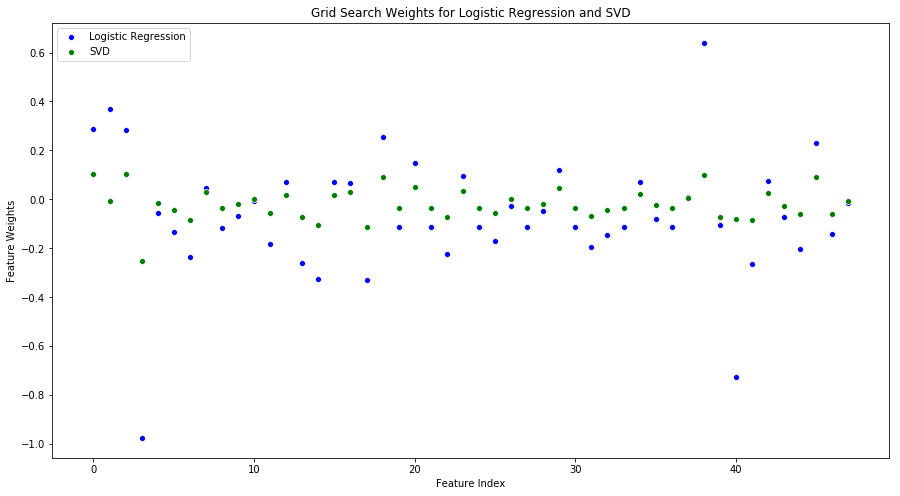

In [31]:
fig = plt.figure(figsize = (15,8))
_= sns.scatterplot(range(X_preprocessed.shape[1]), 
                lr_plot.coef_[0,:] , 
                label='Logistic Regression', 
                alpha = 1, 
                color = 'b')

_ = sns.scatterplot(range(X_preprocessed.shape[1]), 
                svd_plot.coef_[0,:] , 
                label='SVD', 
                alpha = 1, 
                color = 'g')

_ = plt.xlabel('Feature Index')
_ = plt.ylabel('Feature Weights')
_ = plt.title('Grid Search Weights for Logistic Regression and SVD')
_ = plt.legend(loc = 2)